In [1]:
import numpy as np 
import torch
from torch import nn
import pandas as pd

from matplotlib import pyplot as plt

In [ ]:
data =  pd.read_csv("navigation_data_multiple_episodes.csv")

In [ ]:
data.head()

In [4]:
data['World_Theta_new'] =  (data['World_Theta'] + np.pi) % (2 * np.pi) - np.pi

In [ ]:
(315+180)%360 - 180

In [4]:
data['World_Theta_new'] = np.where((data['World_Theta'] > np.pi) | (data['World_Theta'] < 0),
                                   -(np.pi - data['World_Theta'] % np.pi),
                                   data['World_Theta'])

In [ ]:
np.rad2deg(data['World_Theta_new']).describe().astype(str)

In [6]:
# 
# # target = ['L', 'Theta']

# # Calculate ground truth midpoints for the chunk
# data['Midpoint_x'] = (data['Bot_x'] + data['Goal_x']) / 2
# data['Midpoint_y'] = (data['Bot_y'] + data['Goal_y']) / 2

In [62]:
L_max = 1.0  # Maximum distance
Theta_max = np.pi / 9  # Maximum angular deviation (20 degrees)

# Function to compute ground truth (L, Theta)
def compute_ground_truth(row):
    # Vector to the goal
    dx = row['Goal_x'] - row['Bot_x']
    dy = row['Goal_y'] - row['Bot_y']
    distance_to_goal = np.sqrt(dx**2 + dy**2)
    
    # Angle to the goal in global frame
    theta_to_goal = np.arctan2(dy, dx)

    theta_to_goal = (theta_to_goal + np.pi) % (2 * np.pi) - np.pi
    
    # Relative angle (Theta) with respect to the bot's current orientation
    relative_theta = theta_to_goal - row['World_Theta_new']
    
    # Normalize relative_theta to [-pi, pi] for proper angle calculation
    relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi
    
    # Determine the sign of L: positive if goal is in the forward-facing hemisphere of the bot
    if relative_theta <0:  # Goal is behind the bot, turn
        L = 0
    else:  # Goal is in front of the bot
        L = min(distance_to_goal, L_max)
    
    # Clip Theta to [-Theta_max, Theta_max]
    Theta = np.clip(relative_theta, -Theta_max, Theta_max)
    
    return pd.Series([L, Theta], index=['L', 'Theta'])

In [ ]:
np.sin(np.pi/9)

In [64]:
data[['Target_L', 'Target_theta']] = data.apply(compute_ground_truth, axis=1)

In [ ]:
data['Target_L'].value_counts()

In [ ]:
np.rad2deg(data['Relative_Theta']).describe().astype(str)

In [ ]:
data[['Target_theta', 'Relative_Theta']].head()

In [131]:
data['turn_angle'] = data['World_Theta'] + data['Predicted_Theta']
data['Target_x'] = data['Bot_x'] + data['Predicted_L'] * np.cos(data['turn_angle'])
data['Target_y'] = data['Bot_y'] + data['Predicted_L'] * np.sin(data['turn_angle'])

In [ ]:
plt.figure(figsize=(10, 8))
for episode in data['Episode'].unique()[20000:20001]:  # Limit to 5 episodes for clarity
    episode_data = data[data['Episode'] == episode]
    plt.scatter(episode_data['Bot_x'], episode_data['Bot_y'], label=f'Episode {episode}')
    # plt.scatter(episode_data['Midpoint_x'], episode_data['Midpoint_y'], color='green', label=f'mid {episode}')
    # plt.scatter(episode_data['Target_x'], episode_data['Target_y'], color='cyan', label=f'mid {episode}')
    plt.scatter(episode_data['Goal_x'].iloc[-1], episode_data['Goal_y'].iloc[-1], color='green', s=50, label=f'Goal {episode}')
    
    # print(episode_data['Prev_Chunk_x'], episode_data['Prev_Chunk_y'])
    # plt.scatter(episode_data['Current_Chunk_x'], episode_data['Current_Chunk_y'], color='red', s=30, label=f'curr Chunk {episode}')
    # plt.scatter(episode_data['Next_Chunk_x'], episode_data['Next_Chunk_y'], color='purple', s=30, label=f'next Chunk {episode}')
    # plt.scatter(episode_data['Prev_Chunk_x'], episode_data['Prev_Chunk_y'], color='yellow', s=10, label=f'prev Chunk {episode}')

plt.title('Robot Trajectory vs. Goal and Chunks')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))

for episode in data['Episode'].unique()[2024:2025]:  # Limit to 5 episodes for clarity
    episode_data = data[data['Episode'] == episode]
    
    # Plot the trajectory points
    plt.scatter(episode_data['Bot_x'], episode_data['Bot_y'], label=f'Episode {episode}')
    plt.scatter(episode_data['Target_x'], episode_data['Target_y'], color='cyan', label=f'target {episode}')
    plt.scatter(episode_data['Goal_x'].iloc[-1], episode_data['Goal_y'].iloc[-1], color='green', s=50, label=f'Goal {episode}')
    
    # Add direction arrows for bot (based on World_Theta_new)
    dx_bot = np.cos(episode_data['World_Theta_new'].values)  # x-direction of bot's orientation
    dy_bot = np.sin(episode_data['World_Theta_new'].values)  # y-direction of bot's orientation
    
    # Plot the arrows indicating the bot's orientation
    for i in range(0, len(dx_bot), 2):
        plt.quiver(
            episode_data['Bot_x'].iloc[i], episode_data['Bot_y'].iloc[i],  # Starting point
            dx_bot[i], dy_bot[i],  # Direction from World_Theta_new
            angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.7, width=0.005
        )
    
    # Add direction arrows for target (based on target's angle to goal)
    # dx_target = np.cos(np.arctan2(episode_data['Goal_y'] - episode_data['Target_y'], episode_data['Goal_x'] - episode_data['Target_x']))
    # dy_target = np.sin(np.arctan2(episode_data['Goal_y'] - episode_data['Target_y'], episode_data['Goal_x'] - episode_data['Target_x']))
    dx_target = np.cos(episode_data['turn_angle'].values)  # x-direction of bot's orientation
    dy_target = np.sin(episode_data['turn_angle'].values)  # y-direction of bot's orientation
    
    # Plot the arrows indicating the target's direction
    for i in range(0, len(dx_target), 2):
        plt.quiver(
            episode_data['Bot_x'].iloc[i], episode_data['Bot_y'].iloc[i],  # Starting point
            dx_target[i], dy_target[i],  # Direction based on target's angle to goal
            angles='xy', scale_units='xy', scale=1, color='red', alpha=0.7, width=0.005
        )

plt.title('Robot Trajectory vs. Goal and Chunks')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.show()


In [151]:
features = ['Bot_x', 'Bot_y', 'Goal_x', 'Goal_y', 'World_Theta']

X = data[features].values
y = data[['Predicted_L', 'Predicted_Theta']].values


#Normalization
extent_feat = np.array([20, 14, 20, 14, 2*np.pi])

extent_tgt = np.array([1, 2*np.pi])

X = X/extent_feat
y = y/extent_tgt

In [152]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [154]:
import pytorch_lightning as pl
import torch.nn.functional as F

class NavigationModel(pl.LightningModule):
    def __init__(self, input_dim, lr=0.001):
        super(NavigationModel, self).__init__()
        self.lr = lr
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2) # Output: [L, Theta]
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)

        turn_angle_pred = x[:, 4] + predictions[:, 1]

        # Compute predicted position
        # pred_x = x[:, 0] + predictions[:, 0] * torch.cos((turn_angle_pred)*2*np.pi)
        # pred_y = x[:, 1] + predictions[:, 0] * torch.sin((turn_angle_pred)*2*np.pi)

        # turn_angle_gt = x[:, 4] + y[:, 1]

        # # Ground truth positions
        # true_x = x[:, 0] + y[:, 0] * torch.cos((turn_angle_gt)*2*np.pi)
        # true_y = x[:, 1] + y[:, 0] * torch.sin((turn_angle_gt)*2*np.pi)

        # Compute loss
        # loss = (self.criterion(pred_x, true_x) + self.criterion(pred_y, true_y))
        angle_loss = self.criterion(predictions, y)
        l_loss = self.criterion(predictions, y)
        loss = l_loss+ angle_loss
        self.log('train_loss', loss, prog_bar=True)
        self.log("train_l_loss", l_loss)
        self.log("train_angle_loss", np.rad2deg(angle_loss.item()*np.pi*2))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)

        #goal positin
        # goal_x = x[:, 2]
        # goal_y = x[:, 3]

        # turn_angle_pred = x[:, 4] + predictions[:, 1]

        # # Compute predicted position
        # pred_x = x[:, 0] + predictions[:, 0] * torch.cos((turn_angle_pred)*2*np.pi)
        # pred_y = x[:, 1] + predictions[:, 0] * torch.sin((turn_angle_pred)*2*np.pi)

        # turn_angle_gt = x[:, 4] + y[:, 1]

        # # Ground truth positions
        # true_x = x[:, 0] + y[:, 0] * torch.cos((turn_angle_gt)*2*np.pi)
        # true_y = x[:, 1] + y[:, 0] * torch.sin((turn_angle_gt)*2*np.pi)


        # # Compute loss
        # loss = self.criterion(pred_x, true_x) + self.criterion(pred_y, true_y)
        angle_loss = self.criterion(predictions, y)
        l_loss = self.criterion(predictions, y)
        loss = l_loss+ angle_loss
        self.log('val_loss', loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [155]:
from torch.utils.data import DataLoader, TensorDataset

# Create PyTorch Dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


In [ ]:
from pytorch_lightning import Trainer

# Initialize the model
input_dim = len(features)
model = NavigationModel(input_dim)

# Initialize the trainer
trainer = Trainer(max_epochs=3, log_every_n_steps=50)

# Train the model
trainer.fit(model, train_loader, val_loader)

1 0.6599999956466576 cc 0 0 to -0.65418826 0.08739402 ori 172.39082113503838
current ori : 0.0, predicted ori: 172.39082113503838
2 4.0245584642661925e-16 cc -0.65418826 0.0873940200000004 to -0.65418826 0.08739402 ori -90.0
current ori : 172.39082113503838, predicted ori: 97.6091788649616
2 1.2888816243442802 cc -0.65418826 0.08739402 to -0.49868738 1.36686083 ori 83.07050297164538
current ori : -90.0, predicted ori: 173.0705029716454
2 0.2888816243442803 cc -0.5335403455112575 1.080089381492899 to -0.49868738 1.36686083 ori 83.07050297164544
current ori : 83.07050297164538, predicted ori: 5.088887490341627e-14
3 0.0 cc -0.49868738 1.36686083 to -0.49868738 1.36686083 ori 0.0
current ori : 83.07050297164544, predicted ori: -83.07050297164544
3 2.967873506948365 cc -0.49868738 1.36686083 to 1.95564562 3.03554974 ori 34.21159090044354
current ori : 0.0, predicted ori: 34.21159090044354
3 1.967873506948365 cc 0.3282794682345803 1.9291115142334339 to 1.95564562 3.03554974 ori 34.211590900

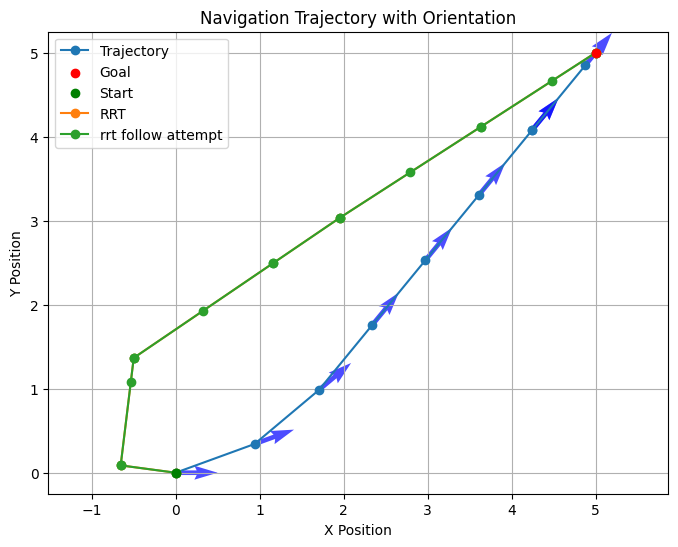

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def navigate_and_plot(model, initial_bot_position, goal_position, max_steps=100, L_max=1.0):
    # Initialize position, orientation, and trajectory
    bot_x, bot_y = initial_bot_position
    goal_x, goal_y = goal_position
    trajectory = [(bot_x, bot_y)]
    orientations = [0]  # Initial orientation (world_theta)


    trajectory_r = [(bot_x, bot_y)]
    orientations_r = [0]  # Initial orientation (world_theta)
    
    rrt_path = np.array([[ 0., 0.        ],
                    [-0.65418826 , 0.08739402],
                    # [-0.65418826 , 0.08739402],
                    # [-0.71786134  ,0.74431543],
                    # [-0.71786134  ,0.74431543],
                    [-0.49868738  ,1.36686083],
                    # [-0.49868738  ,1.36686083],
                    # [ 0.72847912  ,2.20120528],
                    [ 1.95564562  ,3.03554974],
                    # [ 3.18281212  ,3.8698942 ],
                    # [ 4.40997862  ,4.70423866],
                    # [ 4.40997862  ,4.70423866],
                    [ 5.          ,5.        ]])

    
    # rrt follwing
    idx = 1
    
    while idx < len(rrt_path):
        wp_x, wp_y = rrt_path[idx][0], rrt_path[idx][1]

        dx = wp_x - bot_x
        dy = wp_y - bot_y
        distance_to_goal = np.sqrt(dx**2 + dy**2)

        relative_theta = np.arctan2(dy, dx)
        relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-pi, pi]
        
        predicted_theta = relative_theta - orientations_r[-1]
        predicted_theta = (predicted_theta + np.pi) % (2 * np.pi) - np.pi

        predicted_L = min(distance_to_goal, 1) if predicted_theta>=0 else 0.
        # predicted_L = min(1, distance_to_goal)

        # predicted_theta = np.clip(predicted_theta, -np.pi/9, np.pi/9)

        # print(f'current ori : {np.rad2deg(orientations[-1])}, predicted ori: {np.rad2deg(predicted_theta)}')

        new_orientation = orientations_r[-1] + predicted_theta
        new_orientation = (new_orientation + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-pi, pi]

        if distance_to_goal <0.1:
            idx +=1

        print(idx, distance_to_goal, "cc" , bot_x, bot_y, "to", wp_x, wp_y, "ori", np.rad2deg(new_orientation))
        print(f'current ori : {np.rad2deg(orientations_r[-1])}, predicted ori: {np.rad2deg(predicted_theta)}')

        # Update bot position
        bot_x += predicted_L * np.cos(new_orientation)
        bot_y += predicted_L * np.sin(new_orientation)

        # print(f'current: ({bot_x}, {bot_y}), goal: {goal_x}, {goal_y}')

        # Save trajectory and orientation
        trajectory_r.append((bot_x, bot_y))
        orientations_r.append(new_orientation)

        # # Check if the bot is near the goal
        # if distance_to_goal < 0.5:  # Threshold for goal proximity
        #     print(f"Goal reached in {step+1} steps!")
        #     break

    bot_x, bot_y = (0, 0)
    # Start navigation
    for step in range(max_steps):
        # Compute relative theta and other features
        dx = goal_x - bot_x
        dy = goal_y - bot_y
        distance_to_goal = np.sqrt(dx**2 + dy**2)

        if distance_to_goal <0.5:
            break

        relative_theta = np.arctan2(dy, dx)
        relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-pi, pi]

        # Input features for the model
        input_features = torch.tensor([[bot_x/20.0, bot_y/14.0, goal_x/20.0, goal_y/14.0, orientations[-1]]], dtype=torch.float32)

        # # Get model prediction
        # with torch.no_grad():
        #     predicted = model(input_features).numpy()[0]  # Predicted [L, Theta]

        # print(predicted)
        # predicted_L = np.clip(predicted[0], 0, L_max)
        # predicted_theta = np.clip(predicted[1]*np.pi*2, -np.pi / 9, np.pi / 9)  # Clip Theta to allowed range
        
        predicted_theta = relative_theta - orientations[-1]
        predicted_theta = (predicted_theta + np.pi) % (2 * np.pi) - np.pi

        predicted_L = 1 if predicted_theta>=0 else 0.
        # predicted_L = min(1, distance_to_goal)

        predicted_theta = np.clip(predicted_theta, -np.pi/9, np.pi/9)

        print(f'current ori : {np.rad2deg(orientations[-1])}, predicted ori: {np.rad2deg(predicted_theta)}')

        new_orientation = orientations[-1] + predicted_theta
        new_orientation = (new_orientation + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-pi, pi]

        # Update bot position
        bot_x += predicted_L * np.cos(new_orientation)
        bot_y += predicted_L * np.sin(new_orientation)

        print(f'current: ({bot_x}, {bot_y}), goal: {goal_x}, {goal_y}')

        

        # Save trajectory and orientation
        trajectory.append((bot_x, bot_y))
        orientations.append(new_orientation)

        # Check if the bot is near the goal
        if distance_to_goal < 0.4:  # Threshold for goal proximity
            print(f"Goal reached in {step+1} steps!")
            break

    trajectory_r = np.array(trajectory_r)
    
    # Plot the trajectory with orientation
    trajectory = np.array(trajectory)
    orientations = np.array(orientations)
    plt.figure(figsize=(8, 6))
    plt.plot(trajectory[:, 0], trajectory[:, 1], '-o', label='Trajectory')
    plt.scatter([goal_x], [goal_y], color='red', label='Goal', zorder=5)
    plt.scatter([trajectory[0, 0]], [trajectory[0, 1]], color='green', label='Start', zorder=5)


    plt.plot(rrt_path[:, 0], rrt_path[:, 1], '-o', label='RRT')

    plt.plot(trajectory_r[:, 0], trajectory_r[:, 1], '-o', label='rrt follow attempt')

    # Add orientation arrows
    arrow_scale = 0.5  # Scale for arrow length
    for i in range(len(trajectory)):
        plt.quiver(
            trajectory[i, 0], trajectory[i, 1],
            arrow_scale * np.cos(orientations[i]), 
            arrow_scale * np.sin(orientations[i]),
            angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.7
        )

    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Navigation Trajectory with Orientation")
    plt.legend()
    plt.grid()
    plt.axis("equal")
    plt.show()

# Example Usage
# Assuming `trainer.model` is your trained PyTorch Lightning model
initial_bot_position = (0, 0)
goal_position = (5, 5)

navigate_and_plot(None, initial_bot_position, goal_position)

In [ ]:
import pandas as pd
import numpy as np
import torch

def generate_navigation_data(num_episodes, csv_file, max_steps=100, L_max=1.0):
    all_data = [] 

    for episode in range(num_episodes):
        initial_bot_position = (np.random.uniform(-10, 10), np.random.uniform(-7, 7))
        goal_position = (np.random.uniform(-10, 10), np.random.uniform(-7, 7))

        # Initialize position, orientation, and trajectory
        bot_x, bot_y = initial_bot_position
        goal_x, goal_y = goal_position
        orientations = [0]  # Initial orientation (world_theta)

        for step in range(max_steps):
            # Compute relative theta and other features
            dx = goal_x - bot_x
            dy = goal_y - bot_y
            distance_to_goal = np.sqrt(dx**2 + dy**2)

            relative_theta = np.arctan2(dy, dx)
            relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-pi, pi]

            predicted_theta = relative_theta - orientations[-1]
            predicted_theta = (predicted_theta + np.pi) % (2 * np.pi) - np.pi

            predicted_L = 1 if predicted_theta >= 0 else 0.0
            predicted_L = min(predicted_L, distance_to_goal)
            predicted_theta = np.clip(predicted_theta, -np.pi / 9, np.pi / 9)

            new_orientation = orientations[-1] + predicted_theta
            new_orientation = (new_orientation + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-pi, pi]

            # Update bot position
            bot_x += predicted_L * np.cos(new_orientation)
            bot_y += predicted_L * np.sin(new_orientation)

            # Append step data
            all_data.append({
                'Episode': episode + 1,
                'Step': step + 1,
                'Bot_x': bot_x,
                'Bot_y': bot_y,
                'Goal_x': goal_x,
                'Goal_y': goal_y,
                'World_Theta': new_orientation,
                'Relative_Theta': relative_theta,
                'Predicted_L': predicted_L,
                'Predicted_Theta': predicted_theta
            })

            # Save orientation
            orientations.append(new_orientation)

            
            if distance_to_goal < 0.5:
                break

    # Save all episodes data to a CSV
    all_data_df = pd.DataFrame(all_data)
    all_data_df.to_csv(csv_file, index=False)
    print(f"Data for {num_episodes} episodes saved to {csv_file}")


num_episodes = 500000
csv_file = "navigation_data_multiple_episodes.csv"

generate_navigation_data(num_episodes, csv_file)

##### Start

In [10]:
!pip freeze

annotated-types==0.7.0
anyio==4.8.0
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1733250440834/work
certifi==2025.1.31
click==8.1.8
colorama @ file:///home/conda/feedstock_root/build_artifacts/colorama_1733218098505/work
comm @ file:///home/conda/feedstock_root/build_artifacts/comm_1733502965406/work
contourpy==1.3.1
cycler==0.12.1
debugpy @ file:///C:/b/abs_bf9oo2vhxp/croot/debugpy_1736269476451/work
decorator @ file:///home/conda/feedstock_root/build_artifacts/decorator_1733236420667/work
docstring_parser==0.16
exceptiongroup @ file:///home/conda/feedstock_root/build_artifacts/exceptiongroup_1733208806608/work
executing @ file:///home/conda/feedstock_root/build_artifacts/executing_1733569351617/work
filelock==3.13.1
fonttools==4.55.8
fsspec==2024.6.1
gitdb==4.0.12
GitPython==3.1.44
h11==0.14.0
httpcore==1.0.7
httpx==0.28.1
idna==3.10
importlib_metadata @ file:///home/conda/feedstock_root/build_artifacts/importlib-metadata_1737420181517/work
ipykernel @ file

In [42]:
# import phi.torch
import torch
# import phi.torch as math
from phi.torch import *

class NavigationNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.control_net = torch.nn.Sequential(
            torch.nn.Linear(6, 16),  # Input: [bot_x, bot_y, goal_x, goal_y, world_theta, relative_theta]
            torch.nn.Tanh(),
            torch.nn.Linear(16, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 2), # Output: [L, delta_theta]
            torch.nn.Tanh()  # Tanh activation for bounded output
        )
        
    def forward(self, current_state):
        return self.control_net(current_state)

In [43]:
def simulate_trajectory(net, initial_pos, goal_pos, max_steps=12):

    current_pos = initial_pos
    theta = math.zeros(initial_pos.shape.non_channel)
    total_loss = 0
    path_length = 0  # Track total distance traveled
    prev_controls = None  # For control smoothness
    
    # --- New: Store trajectory for final position loss ---
    trajectory = [current_pos]

    eps = 1e-6

    
    for step in range(max_steps):
        delta_pos = goal_pos - current_pos

        # Temporal discount factor ---
        temporal_weight = 0.85 ** (step*-1)
        
        # Calculate relative angle using existing vector components
        relative_theta = math.arctan(delta_pos.vector['y'], divide_by=delta_pos.vector['x']+eps) - theta

        relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi 
        
        # Network input
        net_input = math.stack([
            current_pos.vector['x']/10, 
            current_pos.vector['y']/7,
            goal_pos.vector['x']/10,
            goal_pos.vector['y']/7,
            theta/math.PI,
            relative_theta/math.PI
        ], channel('input_features'))
        
        # Network prediction
        controls = math.native_call(net, net_input)
        L = controls.vector[0]
        delta_theta = controls.vector[1]*math.PI

        if prev_controls is not None:
            control_change = math.vec_squared(controls - prev_controls)
            total_loss += 0.25 * math.mean(control_change)
        prev_controls = controls

        # Update orientation with physical constraints
        # theta += math.clip(delta_theta, -math.PI/9, math.PI/9)
        theta += delta_theta

        theta = (theta + np.pi) % (2 * np.pi) - np.pi 
        
        # Calculate movement using existing vector dimension
        delta_x = L * math.cos(theta)
        delta_y = L * math.sin(theta)

        movement = math.stack([delta_x, delta_y], dim=channel(vector='x,y'))

        # --- New: Track path length ---
        path_length += math.vec_length(movement)
        
        # Update position
        new_pos = current_pos + movement
        trajectory.append(new_pos)

        # --- Improved: Discounted position loss ---
        position_loss = temporal_weight * math.vec_length(delta_pos)
        control_loss = 0.1 * (math.abs(delta_theta))
        
        total_loss += math.mean(position_loss  + control_loss) #
        
        current_pos = math.where(math.vec_length(delta_pos) > 0.1, new_pos, current_pos)
    
    final_pos_loss = 10.0 * math.vec_length(trajectory[-1] - goal_pos)
    
    # --- New: Path efficiency penalty ---
    straight_line_dist = math.vec_length(goal_pos - initial_pos)
    efficiency_loss = 0.9 * (path_length / (straight_line_dist + eps))  # Prevent div/0
    
    return total_loss + math.mean(final_pos_loss + efficiency_loss)


In [50]:
from phi.torch.flow import batch, channel

def generate_batch(batch_size, min_distance=2.0, max_distance=12):
    batch_dim = batch(samples=batch_size)
    vec_dim = channel(vector='x,y')
    
    # Generate initial positions
    initial_x = math.random_uniform(batch_dim, low=-8, high=8)
    initial_y = math.random_uniform(batch_dim, low=-6,  high=6)
    initial_pos = math.stack([initial_x, initial_y], vec_dim)
    
    # Generate random displacement direction (angles)
    angle = math.random_uniform(batch_dim, low=-math.pi, high=math.pi)
    
    # Generate displacement magnitudes between [min_distance, 2*min_distance]
    distance = math.random_uniform(batch_dim, low=min_distance, high=max_distance)
    
    # Compute displacement components
    dx = distance * math.cos(angle)
    dy = distance * math.sin(angle)
    
    # Apply displacement to initial positions
    goal_x = (initial_x + dx)
    goal_y = (initial_y + dy)
    
    # Clamp goals to stay within bounds
    goal_x = math.clip(goal_x, -7.9, 7.9)
    goal_y = math.clip(goal_y, -5.9, 5.9)
    
    goal_pos = math.stack([goal_x, goal_y], vec_dim)
    
    return initial_pos, goal_pos

ImportError: cannot import name 'rotation_matrix' from 'phi.geom._functions' (c:\Users\rahat\miniconda3\envs\phi\Lib\site-packages\phi\geom\_functions.py)

In [36]:
def physics_loss(net, initial_pos, goal_pos):
    return simulate_trajectory(net, initial_pos, goal_pos)

In [37]:
import matplotlib.pyplot as plt
import torch

def plot_trajectory(net, initial_pos, goal_pos, max_steps=12):
    """Simulate and plot a single trajectory using PyTorch tensors"""
    with torch.no_grad():
        current_pos = initial_pos.clone()
        goal_pos = goal_pos.clone()

        print(current_pos, goal_pos)
        
        theta = torch.zeros_like(current_pos[0])
        positions = []
        
        for stp in range(max_steps):
            delta_pos = goal_pos - current_pos
            relative_theta = torch.atan2(delta_pos[1], delta_pos[0]) - theta

            relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi
            
            net_input = torch.stack([
                current_pos[0]/8, current_pos[1]/6,
                goal_pos[0]/8, goal_pos[1]/6,
                theta/math.PI, relative_theta/math.PI
            ], dim=-1).unsqueeze(0)
            
            controls = net(net_input)[0]
            L = controls[0]
            delta_theta = controls[1]*math.PI

            # print(L, delta_theta, theta, torch.clip(delta_theta, -math.PI/9, math.PI/9))

            theta = theta + delta_theta
            theta = (theta + np.pi) % (2 * np.pi) - np.pi 


            # print("step", stp, " ", np.rad2deg(theta), net_input)
        
            
            # theta += delta_theta
            movement = torch.stack([
                L * torch.cos(theta),
                L * torch.sin(theta)
            ])
            
            current_pos += movement
            # Append a copy of the numpy array to avoid reference issues
            positions.append(current_pos.cpu().numpy().copy())  # Fixed line
            
            if torch.norm(delta_pos) < 0.1:
                break
        
        positions = np.array(positions)
        # Rest of the plotting code remains the same
        plt.figure(figsize=(8, 6))
        plt.plot(positions[:, 0], positions[:, 1], 'b-o', markersize=4, label='Path')
        plt.scatter(positions[0, 0], positions[0, 1], c='green', s=200, marker='*', label='Start')
        plt.scatter(goal_pos[0].item(), goal_pos[1].item(), c='red', s=200, marker='X', label='Goal')
        plt.title("Navigation Trajectory")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid(True)
        plt.axis('equal')
        plt.legend()
        plt.show()


In [39]:
import numpy as np

net = NavigationNet()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

for epoch in range(10000):
    # Generate batch using PhiFlow
    initial_pos, goal_pos = generate_batch(512, min_distance=2.0, max_distance=10.0)

    optimizer.zero_grad()
    output = physics_loss(net, initial_pos, goal_pos)
    loss = output[0] if isinstance(output, tuple) else output
    total_loss = loss.sum  # Sum the loss to get a scalar

    # Skip backward and step if loss is NaN/Inf
    if not torch.isfinite(total_loss):
        print(f"Epoch {epoch}: Loss is NaN/Inf, skipping update.")
        continue

    total_loss.backward()  # Backpropagate

    # Clip gradients to prevent explosion (adjust max_norm as needed)
    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

    # Check for NaNs in gradients
    has_nan = False
    for p in net.parameters():
        if p.grad is not None and not torch.all(torch.isfinite(p.grad)):
            has_nan = True
            break

    if has_nan:
        print(f"Epoch {epoch}: NaN detected in gradients, skipping step.")
        optimizer.zero_grad()  # Clear gradients to prevent contamination
    else:
        optimizer.step()  # Update parameters if no NaNs

    # Logging and plotting
    if epoch % 500 == 0:
        with torch.no_grad():
            initial_pos, goal_pos = generate_batch(1, 4)
            initial_torch = initial_pos.native("samples,vector").squeeze(0)
            goal_torch = goal_pos.native("samples,vector").squeeze(0)

            loss = physics_loss(net, initial_pos, goal_pos)
            print(f"Epoch {epoch}, Loss: {loss.native().item():.4f}")

            plot_trajectory(net, initial_torch, goal_torch)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [21]:
with torch.no_grad():
    initial_torch = torch.tensor([4.5, -3.2], dtype=torch.float32)
    goal_torch = torch.tensor([2.1, -6.1], dtype=torch.float32)

    loss = physics_loss(net, initial_torch, goal_torch)
    # print(f"Epoch {epoch}, Loss: {loss.native().item():.4f}")

    plot_trajectory(net, initial_torch, goal_torch, 60)

NameError: name 'initial_pos' is not defined

In [10]:
torch.save(net, 'nav_model.pth')

/var/folders/zf/94x0k5092zgfxzfr4p5680gc0000gn/T/ipykernel_95024/382003188.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn2 = torch.load('nav_model.pth')


In [12]:
nn2

NavigationNet(
  (control_net): Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=2, bias=True)
    (11): Tanh()
  )
)